In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_csv("/content/인구_쓰레기배출_데이터.csv", encoding='cp949') # Changed line: Added encoding='cp949'
y = data['연간 쓰레기 배출량']
del data['연간 쓰레기 배출량']
del data['지역']
del data['시군구']

X = data

for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].str.replace(',', '').astype(float)

y = y.str.replace(',', '').astype(float)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print("R^2 Score:", r2)

print(X)

target_data = pd.read_csv("/content/전북특별자치도 전주시_인구현황.csv", encoding='cp949')
del target_data['구분']
target_input_X = target_data

print(target_input_X)

y_target_pred = model.predict(target_input_X)
final_data = pd.read_csv("/content/전북특별자치도 전주시_인구현황.csv", encoding='cp949')
final_data["연간 쓰레기 배출량 예측 값"]=y_target_pred

print(final_data)

final_data.to_csv("./result.csv")

R^2 Score: 0.9224200691602418
          인구수       세대수
0    152211.0   72524.0
1    130785.0   63139.0
2    233284.0  109805.0
3    288234.0  133305.0
4    351252.0  169291.0
..        ...       ...
224   38104.0   20868.0
225   61131.0   30659.0
226   42898.0   24185.0
227  507594.0  222599.0
228  192157.0   88756.0

[229 rows x 2 columns]
      인구수    세대수
0    9646   4885
1    3549   2242
2   10362   5456
3    4881   2594
4    5823   3113
5    7916   4306
6   13510   6330
7   18950   9204
8   38869  17539
9   11847   7009
10  43236  18596
11  11582   5336
12  12294   6038
13  20663   9155
14  12809   5881
15   9115   4453
16  13835   5970
17  38595  16731
18  36079  18556
19  12531   6522
20  17185   7423
21  10241   5707
22  30137  14449
23  20643  10992
24   8041   5834
25   9449   5175
26   7354   4506
27  11939   5933
28  13795   7669
29  18593   7887
30  64691  24347
31  26465  11126
32  12032   6263
33  15887   7125
34  35931  13029
       구분    인구수    세대수  연간 쓰레기 배출량 예측 값
0    

최적 모델 - 손실 함수: L1, 은닉층 수: 4, 노드 수: 64
테스트 R^2 Score: 0.9637566413998566
최적 모델 저장 위치: models/model_L1_4_layers_64_units.pth


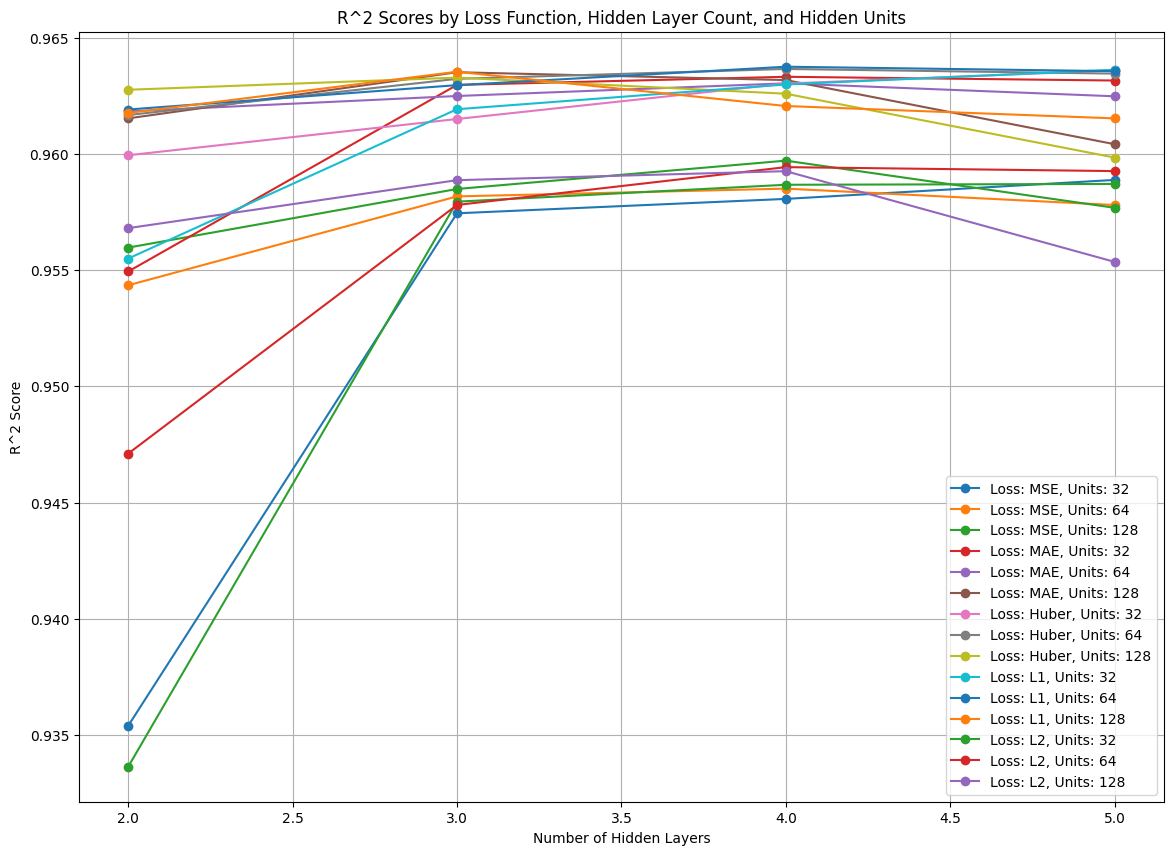

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

data = pd.read_csv("/content/인구_쓰레기배출_데이터.csv", encoding='cp949') # Changed line: Added encoding='cp949'
y = data['연간 쓰레기 배출량']
del data['연간 쓰레기 배출량']
del data['지역']
del data['시군구']

X = data

for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].str.replace(',', '').astype(float)

y = y.str.replace(',', '').astype(float)

# 데이터 분리 및 정규화
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensor 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)


# 하이퍼파라미터 그리드 설정
loss_functions = {
    'MSE': nn.MSELoss(),
    'MAE': nn.L1Loss(),
    'Huber': nn.SmoothL1Loss(),
    'L1': nn.L1Loss(),
    'L2': nn.MSELoss()
}
hidden_layers_options = [2, 3, 4, 5]
hidden_units_options = [32, 64, 128]

# 최적 모델 저장을 위한 변수 초기화
best_model = None
best_r2_score = float('-inf')
best_params = {}
results = []  # 결과 저장용 리스트

# 모델 저장 폴더 생성
os.makedirs("models", exist_ok=True)

# Grid Search 구현
for loss_name, criterion in loss_functions.items():
    for hidden_layers in hidden_layers_options:
        for hidden_units in hidden_units_options:
            # MLP 모델 정의
            class MLPRegressor(nn.Module):
                def __init__(self, hidden_layers, hidden_units):
                    super(MLPRegressor, self).__init__()
                    layers = [nn.Linear(2, hidden_units), nn.ReLU()]
                    for _ in range(hidden_layers - 1):
                        layers += [nn.Linear(hidden_units, hidden_units), nn.ReLU()]
                    layers.append(nn.Linear(hidden_units, 1))
                    self.model = nn.Sequential(*layers)

                def forward(self, x):
                    return self.model(x)

            # 모델 초기화 및 학습 설정
            model = MLPRegressor(hidden_layers, hidden_units)
            optimizer = optim.Adam(model.parameters(), lr=0.01)
            num_epochs = 500

            # 모델 학습
            for epoch in range(num_epochs):
                model.train()
                optimizer.zero_grad()
                y_pred_train = model(X_train_tensor)
                loss = criterion(y_pred_train, y_train_tensor)
                loss.backward()
                optimizer.step()

            # 모델 평가
            model.eval()
            with torch.no_grad():
                y_pred_test = model(X_test_tensor)
                y_pred_test_np = y_pred_test.numpy()
                test_r2_score = r2_score(y_test, y_pred_test_np)  # R^2 점수로 평가

            # 결과 저장
            results.append({
                'loss_name': loss_name,
                'hidden_layers': hidden_layers,
                'hidden_units': hidden_units,
                'r2_score': test_r2_score
            })

            # 현재 모델 저장 및 성능 비교
            model_path = f"models/model_{loss_name}_{hidden_layers}_layers_{hidden_units}_units.pth"
            torch.save(model.state_dict(), model_path)

            if test_r2_score > best_r2_score:
                best_r2_score = test_r2_score
                best_model = model
                best_params = {'loss': loss_name, 'hidden_layers': hidden_layers, 'hidden_units': hidden_units}
                best_model_path = model_path

# 결과 출력
print(f"최적 모델 - 손실 함수: {best_params['loss']}, 은닉층 수: {best_params['hidden_layers']}, 노드 수: {best_params['hidden_units']}")
print(f"테스트 R^2 Score: {best_r2_score}")
print(f"최적 모델 저장 위치: {best_model_path}")

# 그래프 시각화
plt.figure(figsize=(14, 10))
for loss_name in loss_functions.keys():
    for hidden_units in hidden_units_options:
        r2_scores = [result['r2_score'] for result in results if result['loss_name'] == loss_name and result['hidden_units'] == hidden_units]
        hidden_layer_counts = [result['hidden_layers'] for result in results if result['loss_name'] == loss_name and result['hidden_units'] == hidden_units]
        plt.plot(hidden_layer_counts, r2_scores, label=f'Loss: {loss_name}, Units: {hidden_units}', marker='o')

plt.title('R^2 Scores by Loss Function, Hidden Layer Count, and Hidden Units')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('R^2 Score')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import torch
import torch.nn as nn

class MLPRegressor(nn.Module):
    def __init__(self, hidden_layers, hidden_units):
        super(MLPRegressor, self).__init__()
        layers = [nn.Linear(2, hidden_units), nn.ReLU()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_units, hidden_units), nn.ReLU()]
        layers.append(nn.Linear(hidden_units, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

hidden_layers = 4
hidden_units = 64
loss_function = 'L1'

# 모델 초기화
model = MLPRegressor(hidden_layers, hidden_units)

# 저장된 모델의 경로
model_path = "models/model_L1_4_layers_64_units.pth"

# 모델 가중치 불러오기
model.load_state_dict(torch.load(model_path))

target_data = pd.read_csv("/content/전북특별자치도 전주시_인구현황.csv", encoding='cp949')
del target_data['구분']

target_input_X = target_data[['인구수', '세대수']].values
target_input_X = torch.tensor(target_input_X, dtype=torch.float32)

with torch.no_grad():
    y_target_pred = model(target_input_X).numpy().flatten()

y_target_pred = y_target_pred.round().astype(int)
final_data = pd.read_csv("/content/전북특별자치도 전주시_인구현황.csv", encoding='cp949')
final_data["연간 쓰레기 배출량 예측 값"] = y_target_pred

print(final_data)
final_data.to_csv("./result.csv", index=False, encoding='cp949')

       구분    인구수    세대수  연간 쓰레기 배출량 예측 값
0     중앙동   9646   4885        584041600
1     풍남동   3549   2242        219686688
2     노송동  10362   5456        629617152
3     완산동   4881   2594        296875552
4    동서학동   5823   3113        354352704
5    서서학동   7916   4306        482485696
6   중화산1동  13510   6330        812492736
7   중화산2동  18950   9204       1143102720
8     서신동  38869  17539       2330250240
9    평화1동  11847   7009        728085888
10   평화2동  43236  18596       2582278144
11   삼천1동  11582   5336        695583680
12   삼천2동  12294   6038        742339968
13   삼천3동  20663   9155       1237004288
14   효자1동  12809   5881        769048960
15   효자2동   9115   4453        550150464
16   효자3동  13835   5970        826557120
17   효자4동  38595  16731       2306504192
18   효자5동  36079  18556       2187335168
19    진북동  12531   6522        760581056
20   인후1동  17185   7423       1026760640
21   인후2동  10241   5707        625632000
22   인후3동  30137  14449       1815865088
23    덕진동  20643

<ipython-input-10-e14f070f9643>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
